# Sentinal2Geomedian

**what does this notebook do?** this notebook builds on the **GettingStartedWithSentinel2** notebook; it ueses a loop to load data from sentinal 2 A and B over a set period of time, for a set area and concatinates them together. The data is then cast to float format and used to calculate the geomedian for the selected time range. visible light bands are then plotted at a tre colour image. 

**Tags**
`Sentinel2`, `products`, `GeoMedian`, `threeBandImage`, `dc.load`, `query`, `beginner`, `plot`, `image`,

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
% pylab notebook
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd

import datacube_stats

# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

Populating the interactive namespace from numpy and matplotlib


In [3]:
def three_band_image_flat(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands from a dataframe with no time dimention, and plots them on the RGB 
    bands of an image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is 
    in degrees or northings
    '''
    y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('title string', fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')
        
def threeBandImage(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an image. 
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is in degrees or northings
    '''
    t, y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour][time].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    imshow(img_toshow)
    ax = plt.gca()
    ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

In [4]:
# open  shapfile and data loat from that

shapefile_loc='/g/data/u46/users/ck9738/shapefiles_aus/box_townsvilS.shp'

#import project area shapefiles
project_area = gpd.read_file(shapefile_loc)

#convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long
project_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)

#find the bounding box that contains all the queried projects
#addig 0.025 degrees to the bounding box to be certain the polygons are captured
coords = project_area.total_bounds
xmin, ymax, xmax, ymin =coords




I am densified (external_values, 1 elements)


In [5]:
#set up peramiters for data loading

sensors= ['s2a_ard_granule'] #pick the sentinal satelites you want

bands_of_int =['red','blue','green','pixel_quality'] #pick the sentinal bands that you want, here i am just using visible light  

query = {
        'lat': (ymin, ymax),
        'lon': (xmin, xmax),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2017-07-20', '2017-08-30')
        }
# use s2b_ard_granule 	 for S2B
data_sent = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query)

In [6]:
data_sent

<xarray.Dataset>
Dimensions:        (time: 4, x: 5712, y: 6133)
Coordinates:
  * time           (time) datetime64[ns] 2017-07-23T00:30:31.026000 ...
  * y              (y) float64 -2.15e+06 -2.15e+06 -2.15e+06 -2.15e+06 ...
  * x              (x) float64 1.554e+06 1.554e+06 1.554e+06 1.554e+06 ...
Data variables:
    red            (time, y, x) int16 179 190 198 189 176 180 176 174 175 ...
    blue           (time, y, x) int16 601 616 603 582 610 613 603 605 608 ...
    green          (time, y, x) int16 601 589 597 607 604 603 603 596 597 ...
    pixel_quality  (time, y, x) uint8 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 ...
Attributes:
    crs:      EPSG:3577


this_sensor = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query)
    
    #retreive projection infromation
crs = this_sensor.crs
crswkt = this_sensor.crs.wkt
affine = this_sensor.affine
    
#make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
clear_pixelsa = this_sensor.pixel_quality != 2
clear_pixelsb = this_sensor.pixel_quality != 3
clear_pixels = clear_pixelsa * clear_pixelsb
clear_data = this_sensor.where(clear_pixels)
    
#data_sent[s2a] = clear_data

data_sent = {}


sensors_used = 0

for i in sensors:
    try:
        this_sensor = s2aws.load(product= i, group_by='solar_day', **query)
    
        #retreive projection infromation
        crs = this_sensor.crs
        crswkt = this_sensor.crs.wkt
        affine = this_sensor.affine
    
        #make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
        clear_pixelsa = this_sensor.pixel_quality != 2
        clear_pixelsb = this_sensor.pixel_quality != 3
        clear_pixels = clear_pixelsa * clear_pixelsb
        clear_data = this_sensor.where(clear_pixels)
    
        data_sent[i] = clear_data
        sensors_used = sensors_used + 1
        print(i+' done')
    except:
        print(i+'dose not have any imagry for this time')
        
        #use masked vs UNmasked for geomedian depending on requierments 

i = 's2a_ard_granule'

this_sensor = s2aws.load(product= i, group_by='solar_day', **query)
    
        #retreive projection infromation
crs = this_sensor.crs
crswkt = this_sensor.crs.wkt
affine = this_sensor.affine
    
        #make a mask for full timeseries// if you aren't using a geomedian you may want this, but we don't need it
clear_pixelsa = this_sensor.pixel_quality != 2
clear_pixelsb = this_sensor.pixel_quality != 3
clear_pixels = clear_pixelsa * clear_pixelsb
clear_data = this_sensor.where(clear_pixels)
    
data_sent[i] = clear_data 
sensors_used = sensors_used + 1
print(i+' done')

In [8]:
#look at the data 
clear_data

<xarray.Dataset>
Dimensions:        (time: 4, x: 5712, y: 6133)
Coordinates:
  * time           (time) datetime64[ns] 2017-05-01T00:21:11.026000 ...
  * y              (y) float64 -2.15e+06 -2.15e+06 -2.15e+06 -2.15e+06 ...
  * x              (x) float64 1.554e+06 1.554e+06 1.554e+06 1.554e+06 ...
Data variables:
    red            (time, y, x) float64 -999.0 -999.0 -999.0 -999.0 -999.0 ...
    blue           (time, y, x) float64 -999.0 -999.0 -999.0 -999.0 -999.0 ...
    green          (time, y, x) float64 -999.0 -999.0 -999.0 -999.0 -999.0 ...
    pixel_quality  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    crs:      EPSG:3577

#concatinate all of the sentinal data together into one xarray, ordered by time, if you have more than one sensor!!


data_sent = xr.concat(data_sent.values(),'time')
data_sent = data_sent.sortby('time')
data_sent.attrs['crs'] = crs
data_sent.attrs['affin|e'] = affine



# this is plotting an image from our timeslice, not geomedian

threeBandImage(data_sent, bands = ['swir1', 'nir1', 'blue'], time = 10)

<IPython.core.display.Javascript object>


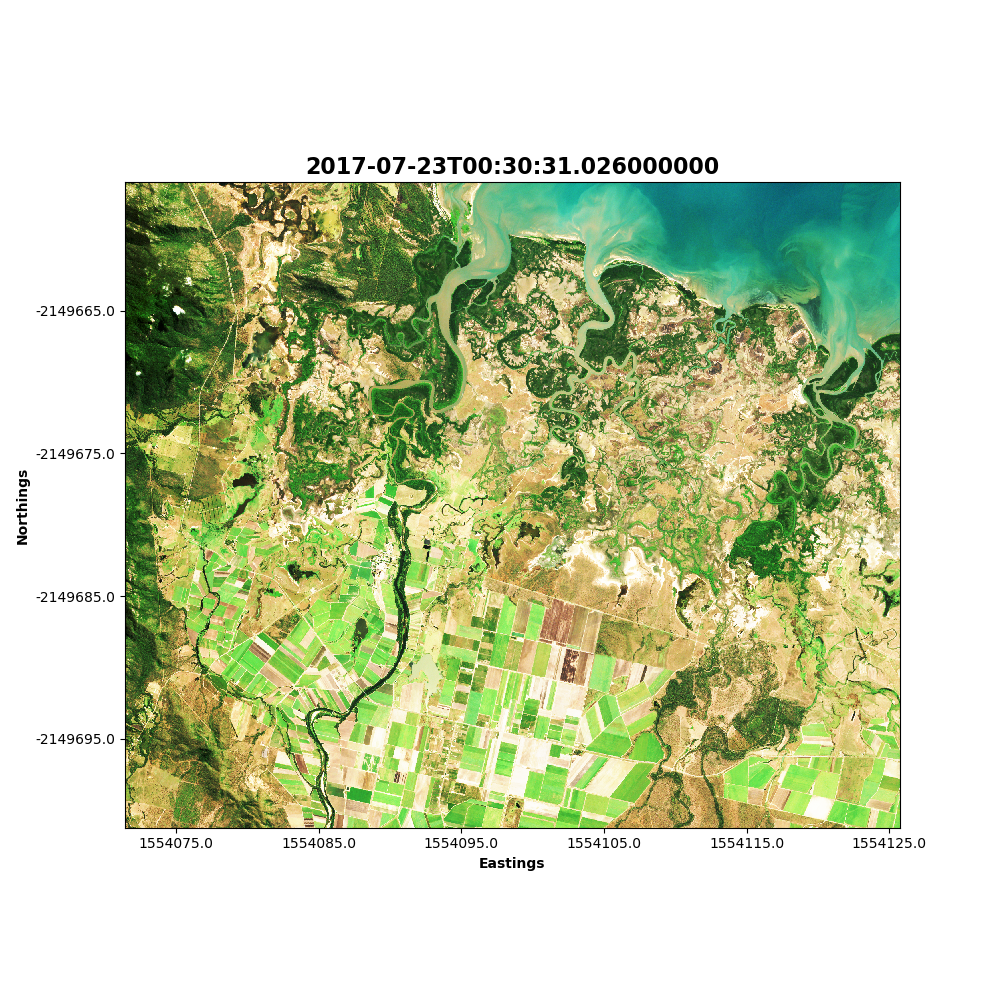

In [8]:
threeBandImage(data_sent, time = 0, bands = ['red', 'green', 'blue'])

In [10]:
#cast the data to float numbers so geomedian calculation will work
data_sent_flt = clear_data.astype(float,casting='safe')

In [11]:
#have a look at the data, you can see it's now in float format
data_sent_flt 

<xarray.Dataset>
Dimensions:        (time: 4, x: 5712, y: 6133)
Coordinates:
  * y              (y) float64 -2.15e+06 -2.15e+06 -2.15e+06 -2.15e+06 ...
  * time           (time) datetime64[ns] 2017-05-01T00:21:11.026000 ...
  * x              (x) float64 1.554e+06 1.554e+06 1.554e+06 1.554e+06 ...
Data variables:
    red            (time, y, x) float64 -999.0 -999.0 -999.0 -999.0 -999.0 ...
    blue           (time, y, x) float64 -999.0 -999.0 -999.0 -999.0 -999.0 ...
    green          (time, y, x) float64 -999.0 -999.0 -999.0 -999.0 -999.0 ...
    pixel_quality  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    crs:      EPSG:3577

In [ ]:
#create geomedian for data
Sentinal_gm=GeoMedian().compute(data_sent_flt)

In [ ]:
#have a look at the geomedian data
Sentinal_gm

In [ ]:
#Prepare geomedian imagery for plotting

rgb = Sentinal_gm.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

In [ ]:
fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('geomedian of selected area') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [12]:
#end notebook

<IPython.core.display.Javascript object>


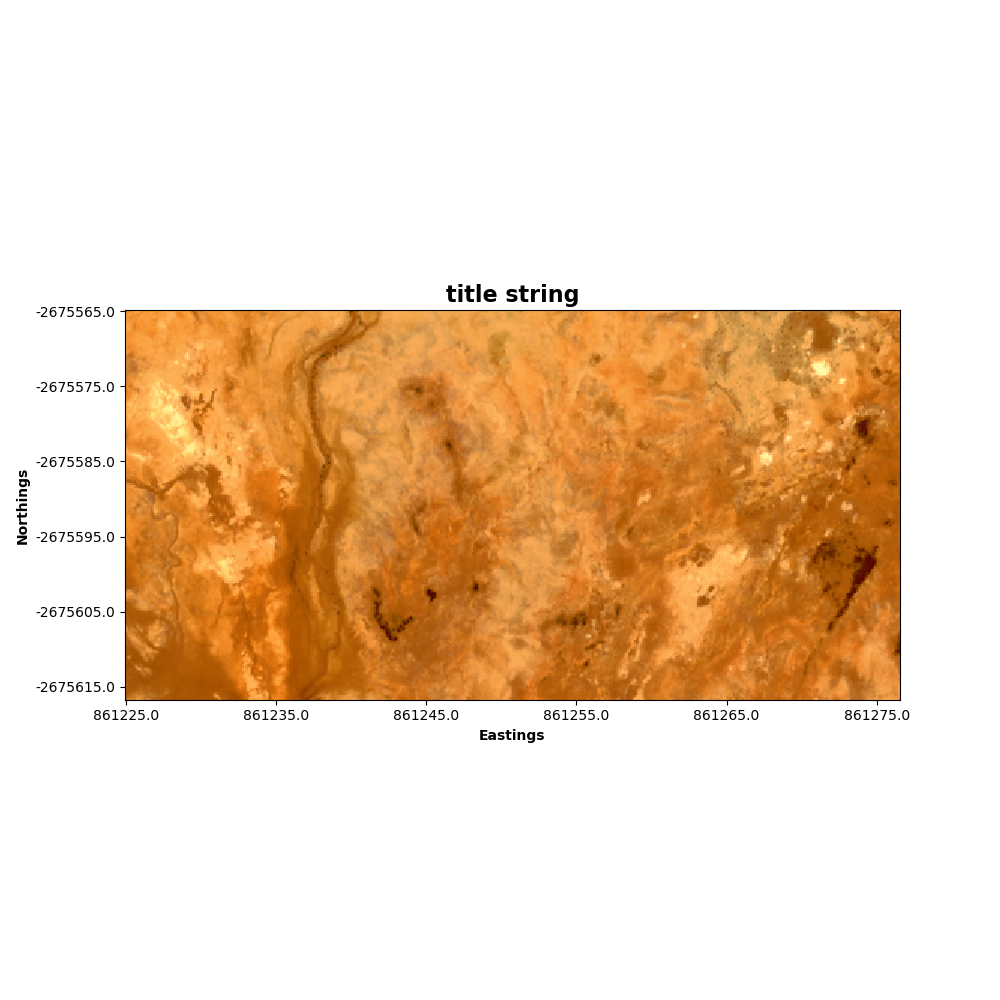

In [13]:
three_band_image_flat(Sentinal_gm, bands = ['red', 'green', 'blue'])